In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from PIL import Image, ImageFilter
from matplotlib import colormaps
import torch.optim as optim
import torch.nn as nn
from os import listdir
from os.path import isfile, join
import re
import random

(32, 32, 4)

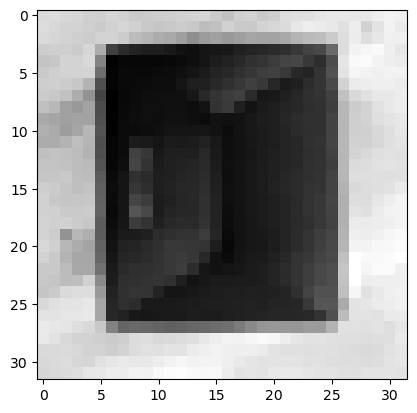

In [36]:
# First, we need to read in the image in a useful way
def get_image(image_path, height, width):
    """Get a numpy array of an image so that one can access values[x][y]."""
    image = Image.open(image_path, "r")
    image = image.resize((height,width))
    pixel_values = list(image.getdata())
    if image.mode == "RGB":
        channels = 3
    elif image.mode == "L":
        channels = 1
    elif image.mode == "RGBA":
        channels = 4
    else:
        print("Unknown mode: %s" % image.mode)
        return None
    pixel_values = np.array(pixel_values).reshape((width, height, channels))
    return pixel_values,height,width


size=32
image,height,width = get_image("photo1.jpg",size,size)
image_bw = (image[:,:,0]+image[:,:,1]+image[:,:,2])
image_bw = image_bw / image_bw.max()
image_bw = image_bw
plt.imshow(image_bw,cmap="gray")
image.shape
#print(image_bw)

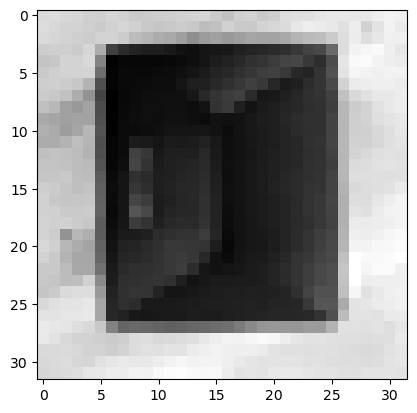

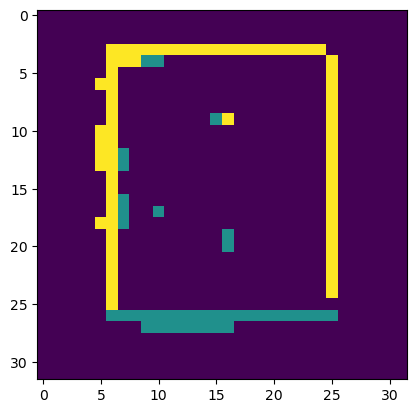

In [27]:
# Now, loop over each point to find edge:
edges = np.zeros_like(image_bw)
param_1 = 2 # Controls how much brighter the pixel outside the target has to be than the target pixel
param_2 = 2 # Controls how many pixels beyond the edge are checked
for i in range((1+param_2),len(image_bw[0:-(1+param_2),0])):
    for j in range((1+param_2),len(image_bw[0,0:-(1+param_2)])):
        # i increases going down, j increases going right.
        # pull the pixel value for the present cell and neighbours
        val = image_bw[i,j]
        val_l = image_bw[i,j-1]
        val_r = image_bw[i,j+1]
        val_u = image_bw[i-1,j]
        val_d = image_bw[i+1,j]
        # check if we are at left edge:
        if val_l > param_1*val:
            # Assume this classifies as an edge
            edge = True
            # Make param_2 steps away from (i,j), and make sure each external point is brighter than each internal point by factor of param_1
            for k in range(1, (1+param_2)):
                if image_bw[i,j-k] < param_1*image_bw[i,j+k]:
                    # If any fail this test, then declassify as an edge
                    edge = False
            # If it passed all tests, give this pixel an edge value of 1
            if edge:
                edges[i,j] = 1
            # Otherwise, give it 0.5, to indicate is was identified as a candidate edge
            else:
                edges[i,j] = 0.5

        # check if we are at right edge:
        if val_r > param_1*val:
            edge = True
            for k in range(1, (1+param_2)):
                if image_bw[i,j+k] < param_1*image_bw[i,j-k]:
                    edge = False
            if edge:
                edges[i,j] = 1
            else:
                edges[i,j] = 0.5

        # check if we are at top edge:
        if val_u > param_1*val:
            edge = True
            for k in range(1, (1+param_2)):
                if image_bw[i-k,j] < param_1*image_bw[i+k,j]:
                    edge = False
            if edge:
                edges[i,j] = 1
            else:
                edges[i,j] = 0.5

        # check if we are at bottom edge:
        if val_d > param_1*val:
            edge = True
            for k in range(1, (1+param_2)):
                if image_bw[i+k,j] < param_1*image_bw[i+k,j]:
                    edge = False
            if edge:
                edges[i,j] = 1
            else:
                edges[i,j] = 0.5

# Clean little dots by filtering points which arent connected to a large edge
for i in range((1+param_2),len(image_bw[0:-(1+param_2),0])):
    for j in range((1+param_2),len(image_bw[0,0:-(1+param_2)])):
        count = 0
        
plt.imshow(image_bw,cmap="gray")
plt.show()
plt.imshow(edges,cmap="viridis")

#for i in range(len(edges[:,0])):
#    for j in range(len(edges[0,:])):
#        if edges[i,j]!=0:
#            plt.scatter(i,j,c="red",alpha = edges[i,j])

Epoch: 0


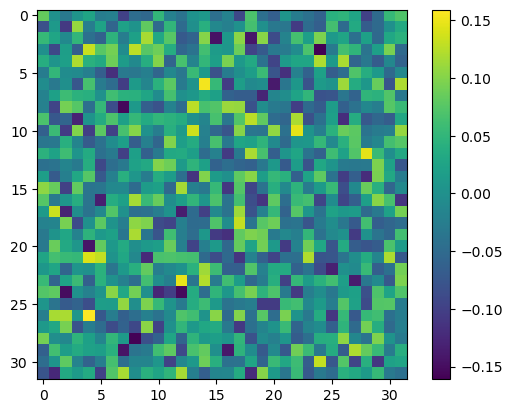

Epoch: 200


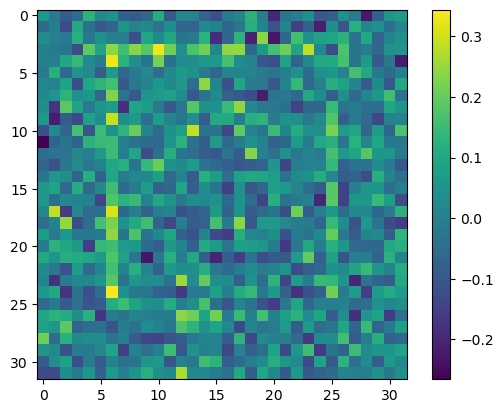

Epoch: 400


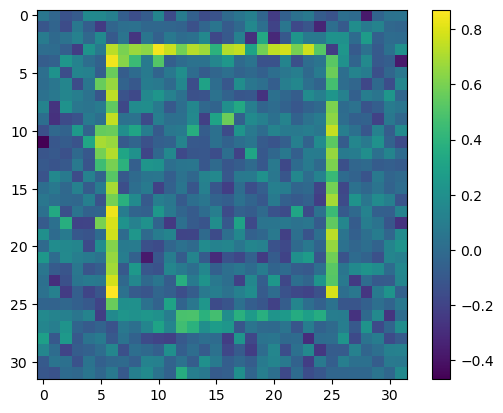

Epoch: 600


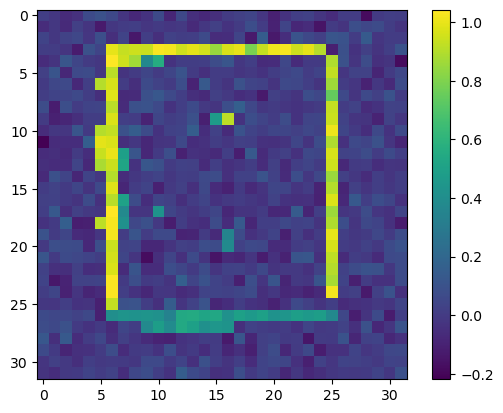

Epoch: 800


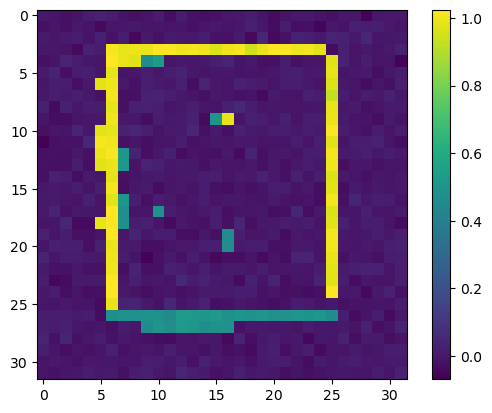

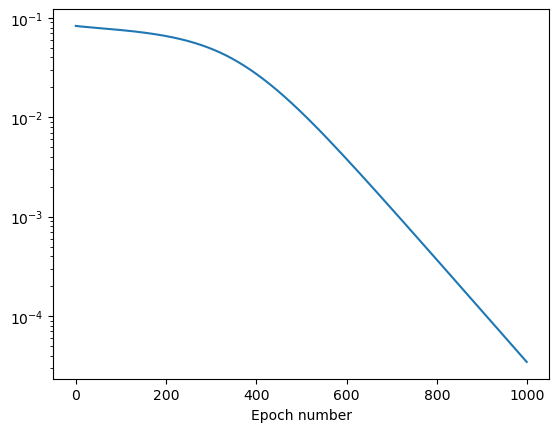

In [34]:
# ravel photo and edge arrays in 1d array
image_1d = torch.tensor(np.reshape(image_bw, (1,np.product(image_bw.shape))))
edges_1d = torch.tensor(np.reshape(edges, (1,np.product(edges.shape))))

myseed = 44
lr = 1e-1
n_epochs = 1000
plot_every = n_epochs/5

device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_train_tensor = image_1d.float().to(device)
y_train_tensor = edges_1d.float().to(device)

torch.manual_seed(myseed)

hidden = 128
hidden2 = 128

model = nn.Sequential(
  nn.Linear(size**2, hidden),
  nn.ReLU(),
  nn.Linear(hidden, hidden2),
  nn.ReLU(),
  nn.Linear(hidden2, hidden2),
  nn.ReLU(),
  nn.Linear(hidden2,size**2),
).to(device)

def mse_loss(input, target):
    return ((input - target) ** 2).sum() / input.data.nelement()
    
optimizer = optim.SGD(model.parameters(), lr=lr)

losses = []

#Train
for epoch in range(n_epochs):

    model.train()
    yhat = model(x_train_tensor)
    
    loss = mse_loss(y_train_tensor, yhat)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss)

    if (epoch % plot_every)==0:
        print("Epoch:",epoch)
        fit = model(x_train_tensor).cpu().detach().numpy().reshape(height,width)
        im=plt.imshow(fit)
        clb=plt.colorbar(im)
        plt.show()

losses_plot=[]
for i in losses:
    losses_plot.append(i.detach().numpy().item())

plt.plot(losses_plot)
plt.xlabel("Epoch number")
plt.yscale("log")
plt.show()

In [37]:
# Now, generalize by looping over many images

In [4]:
def get_image(image_path, height, width):
    """Get a numpy array of an image so that one can access values[x][y]."""
    image = Image.open(image_path, "r")
    image = image.resize((height,width))
    pixel_values = list(image.getdata())
    if image.mode == "RGB":
        channels = 3
    elif image.mode == "L":
        channels = 1
    elif image.mode == "RGBA":
        channels = 4
    else:
        print("Unknown mode: %s" % image.mode)
        return None
    pixel_values = np.array(pixel_values).reshape((width, height, channels))
    return pixel_values[:,:,0]/pixel_values[:,:,0].max()

def find_edges(image, param_1 = 2, param_2 = 2):
    # param_1 controls how much brighter the pixel outside the target has to be than the target pixel
    # param_2 controls how many pixels beyond the edge are checked
    edges = np.zeros_like(image)
    for i in range((1+param_2),len(image[0:-(1+param_2),0])):
        for j in range((1+param_2),len(image[0,0:-(1+param_2)])):
            # i increases going down, j increases going right.
            # pull the pixel value for the present cell and neighbours
            val = image[i,j]
            val_l = image[i,j-1]
            val_r = image[i,j+1]
            val_u = image[i-1,j]
            val_d = image[i+1,j]
            # check if we are at left edge:
            if val_l > param_1*val:
                # Make param_2 steps away from (i,j), and sum the pixel values, to quantify how edgy it is
                inner=0
                outer=0
                for k in range(1, (1+param_2)):
                    inner+=image[i,j+k]
                    outer+=image[i,j-k]
                edges[i,j]=(outer-inner)/(outer+inner)
    
            # check if we are at right edge:
            if val_r > param_1*val:
                inner=0
                outer=0
                for k in range(1, (1+param_2)):
                    inner+=image[i,j-k]
                    outer+=image[i,j+k]
                edges[i,j]=(outer-inner)/(outer+inner)
    
            # check if we are at top edge:
            if val_u > param_1*val:
                inner=0
                outer=0
                for k in range(1, (1+param_2)):
                    inner+=image[i+k,j]
                    outer+=image[i-k,j]
                edges[i,j]=(outer-inner)/(outer+inner)
    
            # check if we are at bottom edge:
            if val_d > param_1*val:
                inner=0
                outer=0
                for k in range(1, (1+param_2)):
                    inner+=image[i-k,j]
                    outer+=image[i+k,j]
                edges[i,j]=(outer-inner)/(outer+inner)
    return edges/edges.max()

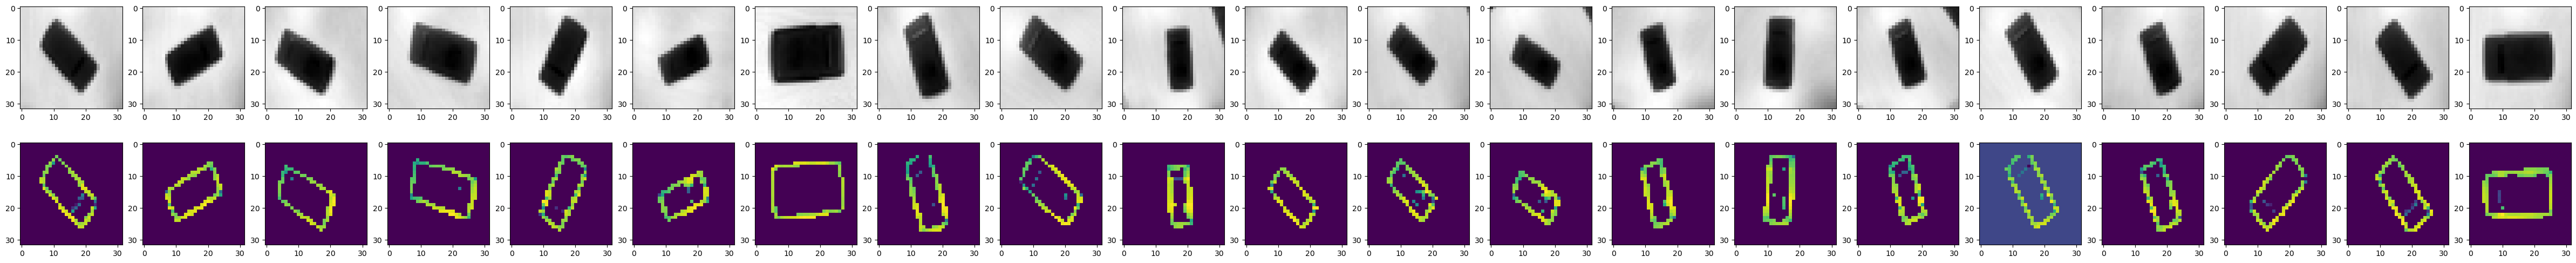

In [43]:
dir = "images/"
size = 32

#########

image_ls = []
edge_ls = []
all_files = [f for f in listdir(dir) if isfile(join(dir, f))]

files=[]
for file in all_files:
    match = re.search(".*\.jpg",file)
    if match != None:
        files.append(file)

fig, ax = plt.subplots(nrows = 2,ncols = len(files)+1,figsize=(3*len(files)+1,3*2))

count = 0
for file in files:
    image = get_image(str(str(dir)+file),size,size)
    edge = find_edges(image,1.5,3)
    image_ls.append(image)
    edge_ls.append(edge)
    ax[0,count].imshow(image,cmap="gray")
    ax[1,count].imshow(edge)
    count+=1

test_image = get_image("test.jpg",size,size)
test_edge = find_edges(test_image,1.5,3)

ax[0,-1].imshow(test_image,cmap="gray")
ax[1,-1].imshow(test_edge)

plt.savefig("training.png")

Epoch: 0


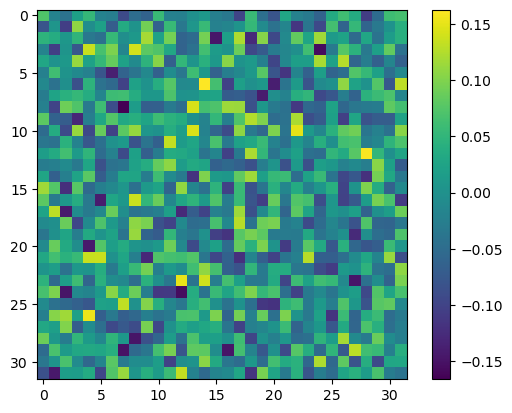

Epoch: 100000


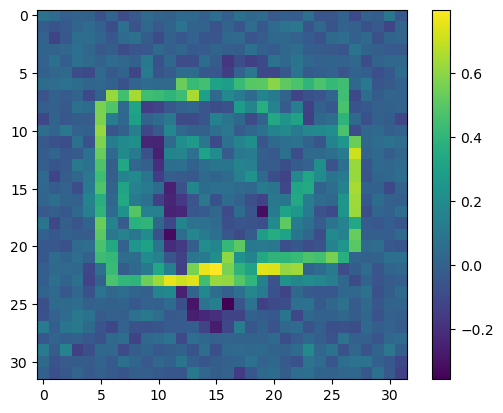

Epoch: 200000


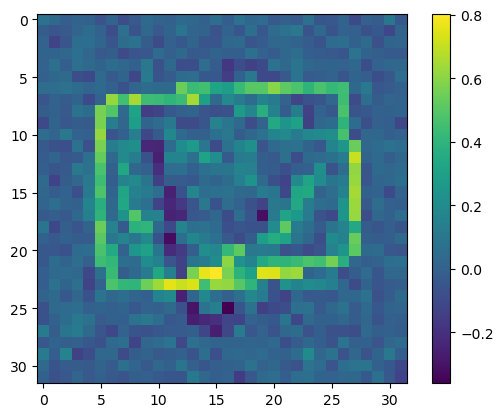

Epoch: 300000


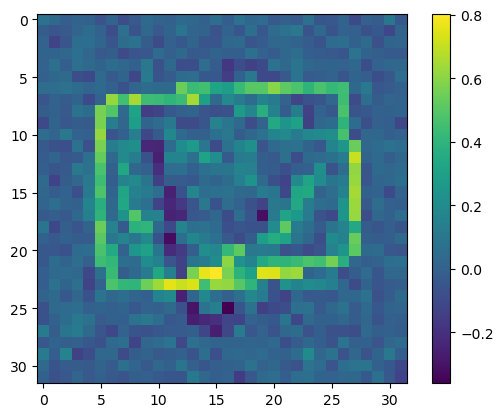

Epoch: 400000


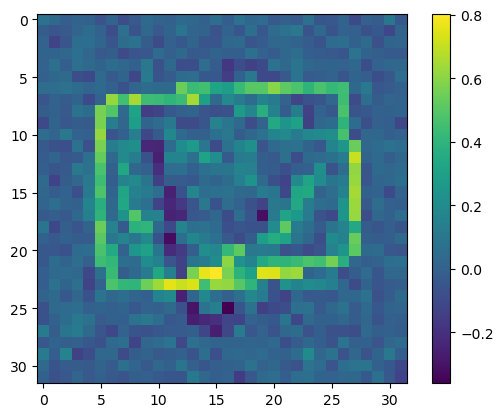

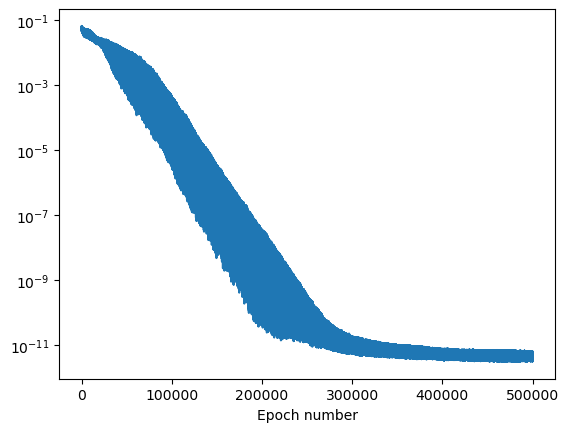

In [38]:
# ravel photo and edge arrays in 1d arra

device = 'cuda' if torch.cuda.is_available() else 'cpu'
myseed = 44
lr = 1e-1
n_epochs = 500000
plot_every = n_epochs/5

images_1d = torch.tensor(np.reshape(image_ls, (len(image_ls),size**2)))
edges_1d = torch.tensor(np.reshape(edge_ls, (len(image_ls),size**2)))
x_train_tensor = images_1d.float().to(device)
y_train_tensor = edges_1d.float().to(device)

test_image_1d = torch.tensor(np.reshape(test_image, (1,size**2))).float().to(device)
test_edge_1d = torch.tensor(np.reshape(test_edge, (1,size**2))).float().to(device)

torch.manual_seed(myseed)

hidden = 128
hidden2 = 128

model = nn.Sequential(
  nn.Linear(size**2, hidden),
  nn.ReLU(),
  nn.Linear(hidden, hidden2),
  nn.ReLU(),
  nn.Linear(hidden2, hidden2),
  nn.ReLU(),
  nn.Linear(hidden2,size**2),
).to(device)

def mse_loss(input, target):
    return ((input - target) ** 2).sum() / input.data.nelement()
    
optimizer = optim.SGD(model.parameters(), lr=lr)

losses = []

#Train
for epoch in range(n_epochs):

    num = random.randint(0,len(images_1d)-1)
    model.train()
    yhat = model(x_train_tensor[num])
    
    loss = mse_loss(y_train_tensor[num], yhat)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss)

    if (epoch % plot_every)==0:
        print("Epoch:",epoch)
        fit = model(test_image_1d).cpu().detach().numpy().reshape(size,size)
        im=plt.imshow(fit)
        clb=plt.colorbar(im)
        plt.show()

losses_plot=[]
for i in losses:
    losses_plot.append(i.detach().numpy().item())

plt.plot(losses_plot)
plt.xlabel("Epoch number")
plt.yscale("log")
plt.show()

In [63]:
image

array([[0.88157895, 0.88157895, 0.88157895, ..., 0.86842105, 0.86403509,
        0.85964912],
       [0.87280702, 0.87719298, 0.87719298, ..., 0.85526316, 0.85526316,
        0.85087719],
       [0.86842105, 0.87280702, 0.87280702, ..., 0.84649123, 0.84649123,
        0.84649123],
       ...,
       [0.89035088, 0.89035088, 0.88596491, ..., 0.77192982, 0.75      ,
        0.72807018],
       [0.87280702, 0.87280702, 0.87719298, ..., 0.76315789, 0.74561404,
        0.71491228],
       [0.86403509, 0.86403509, 0.86842105, ..., 0.75438596, 0.73245614,
        0.70614035]])

In [32]:
random.randint(0,len(images_1d)-1)

2